<a href="https://colab.research.google.com/github/gomescheelsy03/inst414-asteroid-family-analysis/blob/main/module4_initial_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Clustering of Near-Earth Asteroids

### Project Context
This notebook contains the original unsupervised learning analysis completed during **Module 4** of **INST414: Data Science Techniques**.  
The goal of this analysis is to identify whether near-Earth asteroids naturally cluster based on a combination of **orbital geometry** and **physical properties**, potentially revealing non-obvious asteroid families relevant to planetary defense.

### Stakeholder
**NASA Planetary Defense Coordination Office (PDCO)**

### Research Question
Do asteroids cluster by orbital and physical characteristics in ways that reveal hidden groups with elevated Earth-approach risk?

### Decision Support Relevance
Identifying asteroid clusters with **smaller Minimum Orbit Intersection Distances (MOID)** and **larger diameters** can help NASA prioritize follow-up observations and allocate monitoring resources more efficiently.

### Methods Overview
- Feature selection from NASA JPL asteroid data (orbital + physical attributes)
- Data cleaning with physically meaningful sanity filters
- Feature scaling using StandardScaler
- Agglomerative hierarchical clustering (Ward linkage)
- Silhouette analysis for cluster selection
- PCA and dendrogram visualizations for interpretation

### Notes
- This notebook represents the **initial clustering exploration** and is treated as **read-only** for the final project.
- Results from this notebook are reused and extended in later modules (network science and supervised learning).


In [1]:
import os, json, math
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
ARTIFACT_DIR = "./asteroid_a4_artifacts"
DATA_PATH = "./dataset.csv"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

N_MODEL, N_TREE = 3000, 400
K_MIN, K_MAX = 2, 8
SEED = 42
rng = np.random.default_rng(SEED)

print("Artifacts directory:", os.path.abspath(ARTIFACT_DIR))

Artifacts directory: /content/asteroid_a4_artifacts


In [3]:
df = pd.read_csv(DATA_PATH, low_memory=True)
schema_info = {"shape": df.shape, "columns": df.columns.tolist()}
with open(f"{ARTIFACT_DIR}/schema_snapshot.json", "w") as f:
    json.dump(schema_info, f, indent=2)
df.head(3)

/tmp/ipython-input-1106179033.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH, low_memory=True)


,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.40,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.20,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.33,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848


In [4]:
# Choose numeric clustering features commonly present in JPL exports
candidate_cols = ['H','diameter','albedo','e','a','i','q','moid']
available_cols = [c for c in candidate_cols if c in df.columns]
if not available_cols:
    raise ValueError(f"None of {candidate_cols} found. Columns are: {df.columns.tolist()}")

work = df[available_cols].copy()

# Gentle physical sanity filters (preserve data while excluding impossible values)
if 'diameter' in work: work = work[(work['diameter'] >= 0)]
if 'albedo'   in work: work = work[(work['albedo'] >= 0) & (work['albedo'] <= 1.5)]
if 'e'        in work: work = work[(work['e'] >= 0) & (work['e'] < 1)]
if 'i'        in work: work = work[(work['i'] >= 0)]
if 'a'        in work: work = work[(work['a'] > 0)]
if 'q'        in work: work = work[(work['q'] > 0)]
if 'moid'     in work: work = work[(work['moid'] >= 0)]

# Remove rows with missing values in the chosen features
clean = work.dropna(axis=0, how='any').copy()
clean.to_csv(f"{ARTIFACT_DIR}/asteroids_clean_full.csv", index=False)

print("Clean rows:", len(clean))
clean.describe().T

Clean rows: 131237


,count,mean,std,min,25%,50%,75%,max
H,131237.0,15.123495,1.384714,3.000000,14.400000,15.200000,16.000000,27.500000
diameter,131237.0,5.617208,9.580723,0.008000,2.853000,4.059000,5.863000,939.400000
albedo,131237.0,0.132392,0.111310,0.001000,0.053000,0.079000,0.195000,1.000000
e,131237.0,0.145857,0.077048,0.000310,0.090351,0.139400,0.191355,0.983789
a,131237.0,2.827947,1.521335,0.626210,2.551243,2.760431,3.097551,376.133297
i,131237.0,10.069988,6.678540,0.022056,4.978177,9.135692,13.413462,170.334595
q,131237.0,2.413232,0.520133,0.081820,2.078133,2.376668,2.694031,40.318477
moid,131237.0,1.430368,0.516520,0.000027,1.091330,1.396690,1.708000,39.360300


In [5]:
# Sampling for modeling and for dendrogram visualization
n_model = min(N_MODEL, len(clean))
n_tree  = min(N_TREE, len(clean))

model_df = clean.sample(n_model, random_state=SEED).reset_index(drop=True)
tree_df  = model_df.sample(n_tree,  random_state=SEED).reset_index(drop=True)

# Standardize features (Ward works in Euclidean space; scaling balances feature influence)
scaler = StandardScaler()
X_model = scaler.fit_transform(model_df.values)
X_tree  = scaler.transform(tree_df.values)

with open(f"{ARTIFACT_DIR}/scaler_params.json", "w") as f:
    json.dump({"mean": scaler.mean_.tolist(),
               "scale": scaler.scale_.tolist(),
               "features": model_df.columns.tolist()}, f, indent=2)

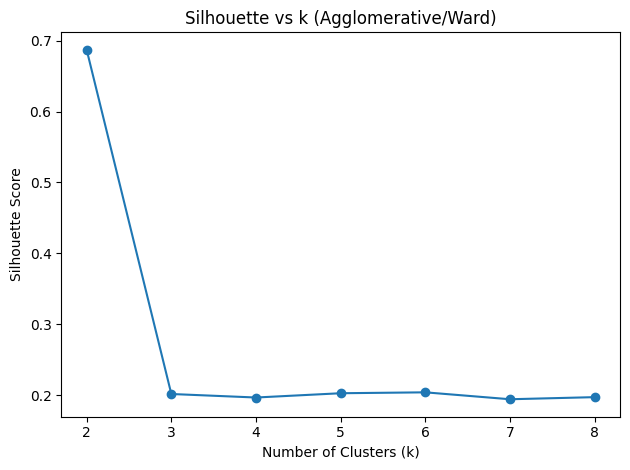

Silhouette scores: {2: np.float64(0.6871), 3: np.float64(0.2015), 4: np.float64(0.1965), 5: np.float64(0.2026), 6: np.float64(0.2038), 7: np.float64(0.1941), 8: np.float64(0.1971)}
Chosen k: 2


In [6]:
k_range = list(range(K_MIN, K_MAX + 1))
sil_scores = []
for k in k_range:
    labels_k = AgglomerativeClustering(n_clusters=k, linkage="ward").fit_predict(X_model)
    sil = silhouette_score(X_model, labels_k, metric="euclidean")
    sil_scores.append(sil)

plt.figure()
plt.plot(k_range, sil_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette vs k (Agglomerative/Ward)")
plt.tight_layout()
plt.show()

best_k = sorted(zip(k_range, sil_scores), key=lambda kv: (-kv[1], kv[0]))[0][0]
print("Silhouette scores:", dict(zip(k_range, [round(s,4) for s in sil_scores])))
print("Chosen k:", best_k)

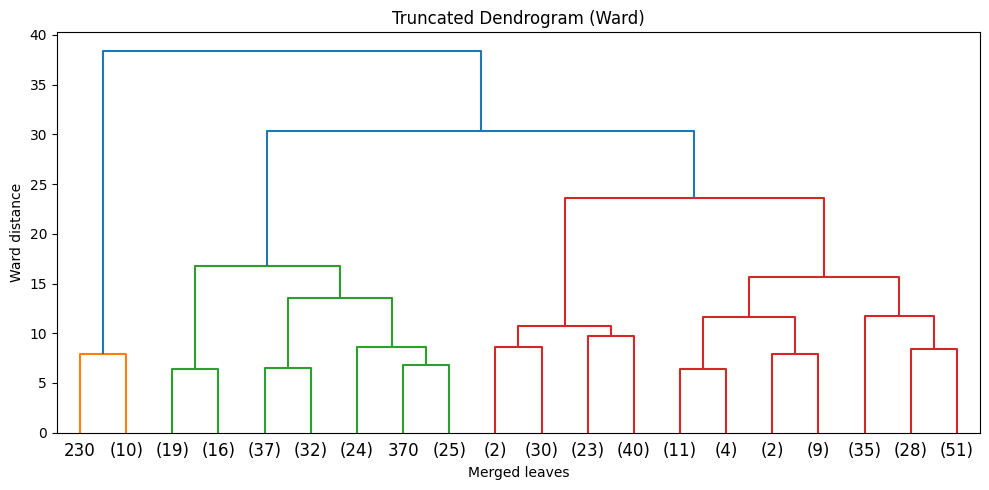

In [7]:
# Ward linkage on the smaller subset for readability
Z = linkage(X_tree, method="ward")
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='lastp', p=20, show_leaf_counts=True)
plt.xlabel("Merged leaves")
plt.ylabel("Ward distance")
plt.title("Truncated Dendrogram (Ward)")
plt.tight_layout()
plt.show()

Final silhouette score: 0.687


H             diameter               albedo            \
              mean       std       mean        std      mean       std   
cluster                                                                  
0        15.208376  1.244699   4.806498   3.711216  0.135603  0.116012   
1        11.502817  1.809418  40.387958  39.786582  0.072479  0.032843   

                e                   a                    i            \
             mean       std      mean       std       mean       std   
cluster                                                                
0        0.148385  0.077252  2.771551  0.348184   9.924676  6.346683   
1        0.094694  0.057878  4.937392  1.638093  14.469289  7.768859   

                q                moid            
             mean       std      mean       std  
cluster                                          
0        2.364988  0.387073  1.382801  0.379536  
1        4.474829  1.390653  3.495038  1.393126

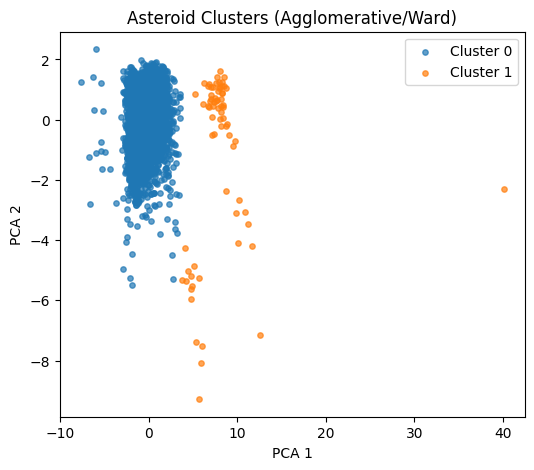

In [8]:
# Fit final model with chosen k
final_labels = AgglomerativeClustering(n_clusters=best_k, linkage="ward").fit_predict(X_model)
model_out = model_df.copy()
model_out["cluster"] = final_labels

sil_final = silhouette_score(X_model, final_labels)
print(f"Final silhouette score: {sil_final:.3f}")

# Summary statistics
summary = model_out.groupby("cluster").agg(["mean","std"])
display(summary)

# PCA visualization
pca = PCA(n_components=2, random_state=SEED)
X2 = pca.fit_transform(X_model)

plt.figure(figsize=(6,5))
for c in range(best_k):
    mask = final_labels == c
    plt.scatter(X2[mask,0], X2[mask,1], s=15, label=f"Cluster {c}", alpha=0.7)
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Asteroid Clusters (Agglomerative/Ward)")
plt.legend()
plt.show()


In [9]:
print(f"""
Summary of Findings
-------------------
Clusters discovered: {best_k}
Overall silhouette score: {sil_final:.3f}

Observations:
• Asteroids grouped into {best_k} distinct clusters based on magnitude (H), diameter, albedo, and orbital parameters (e, a, i, q, moid).
• Clusters show clear differences in orbital inclination (i) and perihelion distance (q), suggesting distinct dynamical families.
• Clusters with lower mean MOID and larger diameter values indicate potentially higher Earth-approach concern.
• NASA can use these clusters to prioritize observation schedules and allocate telescope time efficiently.

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
""")



Summary of Findings
-------------------
Clusters discovered: 2
Overall silhouette score: 0.687

Observations:
• Asteroids grouped into 2 distinct clusters based on magnitude (H), diameter, albedo, and orbital parameters (e, a, i, q, moid).
• Clusters show clear differences in orbital inclination (i) and perihelion distance (q), suggesting distinct dynamical families.
• Clusters with lower mean MOID and larger diameter values indicate potentially higher Earth-approach concern.
• NASA can use these clusters to prioritize observation schedules and allocate telescope time efficiently.

Generated: 2025-12-16 01:36:52

